### 分别使用单独的模型训练：
* Inception

#### 预处理数据
    由于之前已经把数据分成了dogs 文件夹和 cats 文件夹，这里就可以使用Keras中的 ImageDataGenerator 来自动处理训练数据：

In [1]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

from tqdm import *
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size=16
image_size = (299,299)

In [3]:
train_gen = ImageDataGenerator()
train_generator = train_gen.flow_from_directory('train3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                                class_mode='binary'
                                               )
valid_gen = ImageDataGenerator()
valid_generator = train_gen.flow_from_directory('valid3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                               class_mode='binary')
test_gen = ImageDataGenerator()
test_generator = train_gen.flow_from_directory('test3',
                                              target_size=image_size,  # all images will be resized to 224x224
                                              batch_size=batch_size,
                                              class_mode=None)

x_train = train_generator
x_valid = valid_generator
x_test = test_generator

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


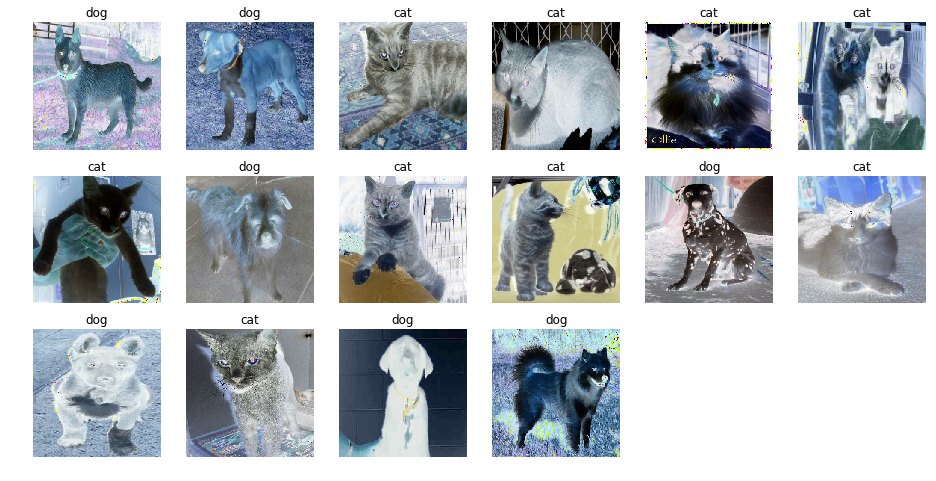

In [4]:
index, batch = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(index, batch)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

### 引入Inception模型：

In [18]:
#process_function = inception_v3.preprocess_input

input_tensor = Input((image_size[0], image_size[1], 3))
x = input_tensor
x = Lambda(inception_v3.preprocess_input)(x)

In [19]:
base_model = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [9]:
from keras.callbacks import TensorBoard

tensorBoard = TensorBoard(log_dir = './logs')
model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//batch_size,
        epochs = 3,
        validation_data = valid_generator,
        validation_steps = valid_generator.samples//batch_size,
        callbacks=[tensorBoard])

Epoch 1/3
1406/1406 [==============================] - 374s 266ms/step - loss: 0.1368 - acc: 0.9510 - val_loss: 0.0515 - val_acc: 0.9848
Epoch 2/3
1406/1406 [==============================] - 371s 264ms/step - loss: 0.1109 - acc: 0.9588 - val_loss: 0.0754 - val_acc: 0.9746
Epoch 3/3
1406/1406 [==============================] - 371s 264ms/step - loss: 0.1108 - acc: 0.9591 - val_loss: 0.0464 - val_acc: 0.9839


In [10]:
model_name = 'Inception_result'
model.save('./Inception_result.h5')

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

### 载入模型，对测试集进行预测

载入模型时候不能用load_model，需要把模型重新写一遍，然后load_weights,是因为在搭建模型时候process_function 使用了匿名函数，如果使用load——model， 那么custumer_objects 就没法传值，会加载错误，如果要用load_model方法加载，可参考Xception文档

In [3]:
process_function = inception_v3.preprocess_input

input_tensor = Input((image_size[0], image_size[1], 3))
x = input_tensor
x = Lambda(process_function)(x)

base_model = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

87916544/87910968 [==============================] - 1s 0us/step


In [4]:
model.load_weights('Inception_result.h5')

In [5]:
def get_image(index):
    img = cv2.imread('test3/test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    return img

test_num = 12500

In [6]:
x_test = np.zeros((test_num, image_size[0], image_size[1], 3), dtype=np.float32)

for i in tqdm(range(0,test_num)):
    x_test[i] = get_image(i+1)

100%|██████████| 12500/12500 [02:00<00:00, 103.58it/s]


In [7]:
y_pred = model.predict(x_test, verbose=1)

12500/12500 [==============================] - 229s 18ms/step


In [8]:
y_pred1 = y_pred.clip(min=0.005, max=0.995)

In [9]:
y_pred2 = y_pred.clip(min=0.006, max=0.996)

In [10]:
s1 = 'id,label\n'
for i, p in enumerate(y_pred1):
    s1 += '%d,%f\n' % (i+1, p)

with open('result_inception_1.csv', 'w') as f:
    f.write(s1)

In [11]:
s2 = 'id,label\n'
for i, p in enumerate(y_pred2):
    s2 += '%d,%f\n' % (i+1, p)

with open('result_inception_2.csv', 'w') as f:
    f.write(s2)

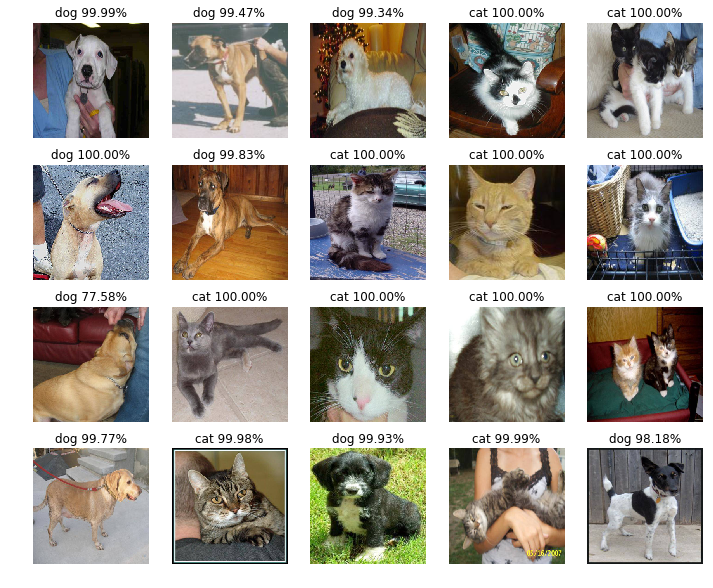

In [13]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB

In [14]:
len(model.layers)

315